### This notebook is to develop and test the decoding pipeline

From - To:

- Spikesorted/spike rates to (encodec) audio
- GPFA to (encodec) audio
- LFADS to (encodec) audio

- (gpfa) HVC to (gpfa) RA
- (lfads) HVC to (lfads) RA

TIMELAG


### imports

In [1]:
# IMPORTS
%matplotlib inline
%run -i '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/all_imports.py'

from FFNNmodel import FFNN, ffnn_predict

### compress audio

In [2]:
def numpy_to_torch(X: np.array):
    '''
    Convert numpy array (N,) to expanded float torch tensor [1xN]. E.g. to feed to EncoDec 
    '''
    
    X = torch.from_numpy(X)
    X = X.expand(1, -1)
    X = X.to(torch.float)
    return X


def encodec_encode(audio: np.ndarray, sr, model):
    '''
    inputs:
        audio: torch.Tensor
        model: encodec.model.EncodecModel
    '''

    # Interpolate audio to desired model sample_rate / n_channels:
    original_sr, target_sr = sr, model.sample_rate
    audio = convert_audio(audio, original_sr, target_sr, model.channels) #[2xN] if model 48kHz
    audio = audio.unsqueeze(0) # [1x2xN]

    # Extract discrete codes from EnCodec
    with torch.no_grad():
        encoded_frames = model.encode(audio)    
   
    return encoded_frames, audio   


def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
        
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = int((valid) // ss)
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(signal, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(signal, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram


def plot_spectrogram(signal, sr, axis, n_window=512, step_ms=1, f_min=1000, f_max=8000, cut_off=5.5e-05):
    '''
    Plot spectrogram given a signal and sampling rate (and figure axis).
    '''
    
    f, tm, sxx = sp.ms_spectrogram(signal, sr, n_window=n_window, step_ms=step_ms, f_min=f_min, f_max=f_max, cut_off=cut_off)
    axis.pcolormesh(tm, f, np.log(sxx), cmap='inferno')
    # ax.set_axis_off()
    axis.set_ylabel('f (kHz)', fontsize=20)
    axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
    
    
    
def resample_by_interpolation_2d(dat, input_fs, output_fs):
    """"
     Linearly resample each entry in a 2D-list from input_fs to output_fs.

     Input: dat[n x Samples]
     input_fs = original sampling frequency.
     output_fs: target sampling frequency.

     Output: [n x (re)Samples]
    """
    resampled_dat = []
    for i in range(np.array(dat).shape[0]):
        resampled_dat.append(resample_by_interpolation_1d(dat[i], input_fs, output_fs))

    return np.array(resampled_dat)
    

def resample_by_interpolation_1d(signal, input_fs, output_fs):
    """"
     Linearly resample an array from input_fs to output_fs.

     Input: signal[1 x Samples]
     input_fs = original sampling frequency.
     output_fs: target sampling frequency.

     Output: [1 x (re)Samples]
    """

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal


def resample_by_furier_1d(signal, num):
    """"
     Resample x to num samples using Fourier method along the given axis.

     Input: signal[1 x Samples]
     num: number. ofsamples in the resampled signal

     Output: [1 x (re)Samples]
    """
    return sp.signal.resample(x, num, t=None, axis=0, window=None, domain='time')


# def normalize_array_2d(X):
#     """"
#     Normalizes array X between 0 and 1.
#     """
#     for x in range()
#     return (x-np.min(x))/(np.max(x)-np.min(x))

def normalize_signal(x):
    """"
    Normalizes signal x between 0 and 1.
    """
    return (x-np.min(x))/(np.max(x)-np.min(x))

## save data

In [3]:
save = False

fig_dir = os.getcwd() + '/paper_figures'
audio_dir = os.getcwd() + '/audio_files'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
if not os.path.exists(audio_dir):
    os.makedirs(audio_dir)

### Data loader

Any loaded data (neural or audio) (raw or factor-based) should have structure: [trials x channels x time].

For each trial, the user is allowed to specify start/end times to shorten the trials (typically necessary to avoid overlap).


<b>decoder training</b> will be done using 90%-10% train-test cross validation (CV).

In [4]:
data_dir = '/home/jovyan/pablo_tostado/bird_song/manifold_paper_analysis/z_w12m7_20-clean_pipeline/'

file_path = data_dir + '/experiment_binsize5ms_z_w12m7_20.pkl'
with open(file_path, 'rb') as pickle_file:
    state_space_analysis_dict = pkl.load(pickle_file)
print("Loaded Dictionary!")


file_path = data_dir + '/audio_experiment_z_w12m7_20.pkl'
with open(file_path, 'rb') as pickle_file:
    audio_array = pkl.load(pickle_file)
print("Loaded Audio!")


Loaded Dictionary!
Loaded Audio!


In [5]:
def generate_trajectories(state_space_analysis_dict: dict, key: str):
    
    if key == 'both':

        key = 'ra_all'
        trajectories_ra = state_space_analysis_dict[key]['gpfa'][key+'_dim24']['trajectories']
        key = 'hvc_all'
        trajectories_hvc = state_space_analysis_dict[key]['gpfa'][key+'_dim24']['trajectories']
        
        return np.concatenate((trajectories_ra, trajectories_hvc), axis=1)

    else:
        return state_space_analysis_dict[key]['gpfa'][key+'_dim24']['trajectories']

In [6]:
key = 'both'
trajectories = generate_trajectories(state_space_analysis_dict, key)

audio_motifs = audio_array['audio_array']
label_motifs = audio_array['labels_array']
fs_audio = audio_array['fs_audio']

In [7]:
# key = 'ra_all'
# trajectories_ra = state_space_analysis_dict[key]['gpfa'][key+'_dim24']['trajectories']

# key = 'hvc_all'
# trajectories_hvc = state_space_analysis_dict[key]['gpfa'][key+'_dim24']['trajectories']

# trajectories = np.concatenate((trajectories_ra, trajectories_hvc), axis=1)
# trajectories = trajectories_

# audio_motifs = audio_array['audio_array']
# label_motifs = audio_array['labels_array']
# fs_audio = audio_array['fs_audio']

In [8]:
trajectories.shape, audio_motifs.shape, label_motifs.shape

((10, 48, 159), (10, 20000), (10, 20000))

### Process Audio

#### Filter 250Hz-8000Hz + noisereduce

In [9]:
audio_motifs.shape

(10, 20000)

In [10]:
# Filter audio
b, a = fh.load_filter_coefficients_matlab('/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/filters/butter_bp_250Hz-8000hz_order4_sr25000.mat')

audio_motifs = fh.noncausal_filter_2d(audio_motifs, b=b, a=a)

In [11]:
# Reduce noise
for m in range(len(audio_motifs)):
    audio_motifs[m] = nr.reduce_noise(audio_motifs[m], sr=fs_audio)

/tmp/ipykernel_3082149/185800929.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_3082149/185800929.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_3082149/185800929.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_3082149/185800929.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_3082149/185800929.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_3082149/185800929.py:123: UserWarning: FixedFormatter should only be used together with Fi

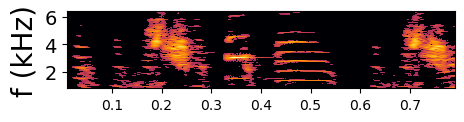

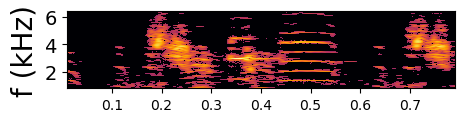

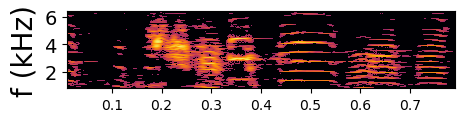

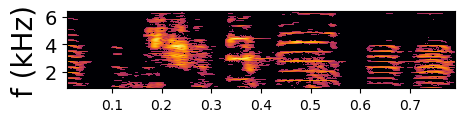

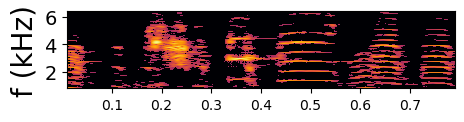

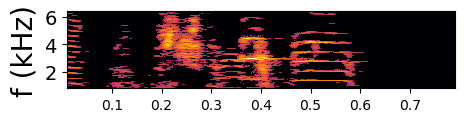

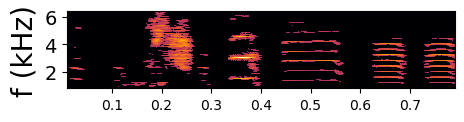

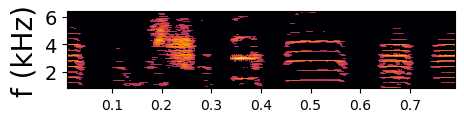

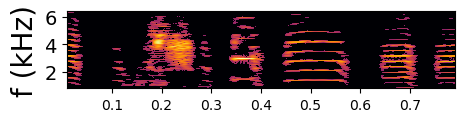

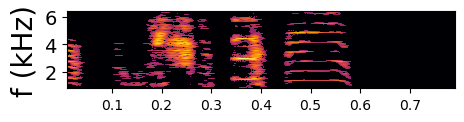

In [12]:
for m in audio_motifs:
    fig, ax = plt.subplots(figsize=(5,1))
    plot_spectrogram(m, fs_audio, ax)

### Instantiate model from Facebook

In [13]:
# Instantiate a pretrained EnCodec model
# model = EncodecModel.encodec_model_24khz()
encodec_model = EncodecModel.encodec_model_48khz()

# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
encodec_model.set_target_bandwidth(24.0)


In [14]:
embeddings_motifs, codes_motifs, scales = [], [], []

for m in audio_motifs:
    # returns embeddings, codes, scale
    embeddings_motifs.append(encodec_encode(numpy_to_torch(m), fs_audio, encodec_model)[0][0][0]) # embeddings 
    codes_motifs.append(encodec_encode(numpy_to_torch(m), fs_audio, encodec_model)[0][0][1]) # codes
    scales.append(encodec_encode(numpy_to_torch(m), fs_audio, encodec_model)[0][0][2]) # scales

embeddings_motifs = torch.squeeze(torch.stack(embeddings_motifs), 1)
embeddings_motifs.shape

torch.Size([10, 128, 120])

In [15]:
scales

[tensor([[2214.1692]]),
 tensor([[2116.2891]]),
 tensor([[1895.8821]]),
 tensor([[1999.8000]]),
 tensor([[2018.8162]]),
 tensor([[1783.2947]]),
 tensor([[1171.7274]]),
 tensor([[1198.6287]]),
 tensor([[1196.7542]]),
 tensor([[894.1633]])]

# Downsample to minimum number of samples

In [30]:
print(trajectories.shape, embeddings_motifs.shape)

samples_trajectories = trajectories.shape[2]
samples_embeddings = embeddings_motifs.shape[2]

trajectories = np.array([resample_by_interpolation_2d(traj, samples_trajectories, samples_embeddings) for traj in trajectories])

print(trajectories.shape, embeddings_motifs.shape)

(10, 48, 159) torch.Size([10, 128, 120])
(10, 48, 120) torch.Size([10, 128, 120])


# Regression

In [31]:
# Once resampled, the bin size ~ 800ms / 120samples = 6.6ms

# Neural 
neural_samp_hist = 9 # neural_ms_hist ~55ms


In [32]:
# Get rid of the starting part of the embeddings, since it won't have a corresponding segment of neural data.
targets = embeddings_motifs[:, :, neural_samp_hist:]

# Find corresponding history of neural activity for each spectrogram slice:
inputs = []
for i in range(targets.shape[2]):
    inputs.append(trajectories[:,:, i:i+neural_samp_hist])
inputs = np.array(inputs).transpose(1, 2, 3, 0) # [trials x dimensions x history x samples]


print(inputs.shape, targets.shape)

(10, 48, 9, 111) torch.Size([10, 128, 111])


### Train / Test split

In [19]:
# Concatenate motifs (reshape arrays to have dimensions [(features * neural_samp_hist) x trials x samples])

inputs = inputs.transpose(1,2,0,3)
targets = targets.transpose(1,0)

print(inputs.shape, targets.shape)

inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], -1)
targets = targets.reshape(targets.shape[0], -1)

print(inputs.shape, targets.shape)


(48, 9, 10, 111) torch.Size([128, 10, 111])
(48, 9, 1110) torch.Size([128, 1110])


In [20]:
# Transpose to to (samples * features)
inputs = inputs.transpose(2, 0, 1)
targets = targets.transpose(1, 0)

print(inputs.shape, targets.shape)

# Create a DataLoader foar your dataset
input_data = torch.from_numpy(inputs) #torch.randn(10*680, 4650)
output_data = targets #torch.randn(10*680, 112)

print(input_data.shape, output_data.shape)

(1110, 48, 9) torch.Size([1110, 128])
torch.Size([1110, 48, 9]) torch.Size([1110, 128])


In [21]:
# Split the data into training, validation, and testing sets

tot_samples = input_data.shape[0]
train_idx, test_idx = int(0.8*tot_samples), int(0.9*tot_samples)

input_train, output_train = input_data[0:train_idx], output_data[0:train_idx]
input_val, output_val = input_data[train_idx:test_idx], output_data[train_idx:test_idx]
input_test, output_test = input_data[test_idx:], output_data[test_idx:]

In [22]:
input_train.shape, input_val.shape, input_test.shape, output_train.shape, output_val.shape, output_test.shape

(torch.Size([888, 48, 9]),
 torch.Size([111, 48, 9]),
 torch.Size([111, 48, 9]),
 torch.Size([888, 128]),
 torch.Size([111, 128]),
 torch.Size([111, 128]))

In [23]:
# Loaders 
train_dataset = TensorDataset(input_train, output_train)
val_dataset = TensorDataset(input_val, output_val)
test_dataset = TensorDataset(input_test, output_test)

# Training FFNN

In [24]:
# Params
batch_size = 10
num_epochs = 40000
lr = 0.0005

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
# class FFNN(nn.Module):

#     def __init__(self, input_dim, output_dim, dropout_prob=0.9):
#         super(FFNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 1024)
#         self.fc2 = nn.Linear(1024, 256)
#         self.fc3 = nn.Linear(256, output_dim)
#         self.elu = nn.ELU()
#         self.dropout = nn.Dropout(p=dropout_prob)

#     def forward(self, x):
#         x = self.elu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.elu(self.fc2(x))
#         x = self.fc3(x)
        
#         return x

In [27]:
# Initialize the neural network and optimizer
input_dim = input_data.shape[1] * input_data.shape[2]
output_dim = output_data.shape[1]
ffnn_model = FFNN(input_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss() 
optimizer = optim.AdamW(ffnn_model.parameters(), lr=lr)


In [28]:
# Print the model architecture and number of params
print(ffnn_model)
print('Number of params: ', sum(p.numel() for p in ffnn_model.parameters() if p.requires_grad))

FFNN(
  (fc1): Linear(in_features=432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (elu): ELU(alpha=1.0)
  (dropout): Dropout(p=0.9, inplace=False)
)
Number of params:  738688


## Load model

In [38]:
modname = '/ffnn_model_HVCtrajectories_num_params517504_epochs40000_lr0.0005.pkl'
# modname = '/ffnn_model_RAtrajectories_num_params517504_epochs40000_lr0.0005.pkl'
# modname = '/ffnn_model_HVC-RAtrajectories_num_params738688_epochs40000_lr0.0005.pkl'
        
# load the model's state dict
models_dir = os.getcwd() + '/models_statedict'
filename = models_dir + modname
loaded_dict = torch.load(filename)

# Extract dict params
input_dim = loaded_dict['input_dim']
output_dim = loaded_dict['output_dim']
neural_samp_hist = loaded_dict['neural_samp_hist']
model_state_dict = loaded_dict['model_state_dict']
train_dataloader = loaded_dict['train_dataloader']
val_dataloader = loaded_dict['val_dataloader']
test_dataloader = loaded_dict['test_dataloader']
if 'conv_params' in loaded_dict.keys(): 
    conv_params = loaded_dict['conv_params']


# Create model:
ffnn_model = FFNN(input_dim, output_dim)
ffnn_model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
# models_dir = os.getcwd() + '/models'
# filename = models_dir + '/ffnn_model_RA-HVCtrajectories_epochs40000_lr0.0005.pkl'
# filename = models_dir + '/ffnn_model_RAtrajectories_epochs40000_lr0.0005.pkl'

# # Load model from pickle
# ffnn_model = pkl.load(open(filename, 'rb'))

In [ ]:
# def train(model, dataloader, optimizer, criterion, num_epochs, val_dataloader=None):    
    
#     # Send model to GPU if available
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)
    
#     model.train()        

#     # Initialize empty lists to track losses and errors
#     tot_train_loss, tot_train_err = [], []
#     tot_val_loss, tot_val_err = [], []
    
#     for epoch in range(num_epochs):
            
#         train_loss = 0.0
#         train_error = 0.0
        
#         for inputs, targets in dataloader:
#             inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)
#             # Linearize inputs torch.Size([batch, features, timestamps]) into torch.Size([batch, features*timestamps])
#             inputs = inputs.view(inputs.shape[0], -1)
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
            
#             train_loss += loss.item()
#             train_error += mean_absolute_error(targets.view(-1).cpu().numpy(), outputs.view(-1).cpu().detach().numpy())
            
#         tot_train_loss.append(train_loss/len(dataloader))
#         tot_train_err.append(train_error/len(dataloader))

#         # Evaluate
#         if val_dataloader:
#             val_loss, val_error = evaluate(model, val_dataloader, criterion)
#             tot_val_loss.append(val_loss/len(val_dataloader))
#             tot_val_err.append(val_error/len(val_dataloader))
        
#         # Print progress every 100 epochs
#         if (epoch + 1) % 100 == 0:  
#             print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {tot_train_loss[-1]}, Training Error: {tot_train_err[-1]}")
#             if val_dataloader: print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {tot_val_loss[-1]}, Validation Error: {tot_val_err[-1]}')
    
#     return tot_train_loss, tot_train_err, tot_val_loss, tot_val_err
        
        
# def evaluate(model, dataloader, criterion):
    
#     # Send model to GPU if available
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)

#     model.eval()
#     val_loss = 0.0
#     val_error = 0.0
    
#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)
#             # Linearize inputs torch.Size([batch, features, timestamps]) into torch.Size([batch, features*timestamps])
#             inputs = inputs.view(inputs.shape[0], -1)
            
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)

#             val_loss += loss.item()
#             val_error += mean_absolute_error(targets.view(-1).cpu().numpy(), outputs.view(-1).cpu().detach().numpy())

    # return val_loss, val_error



In [35]:
tot_train_loss, tot_train_err, tot_val_loss, tot_val_err = train(ffn_model, train_dataloader, optimizer, criterion, num_epochs, val_dataloader=val_dataloader)
        

NameError: name 'train' is not defined

NameError: name 'tot_train_loss' is not defined

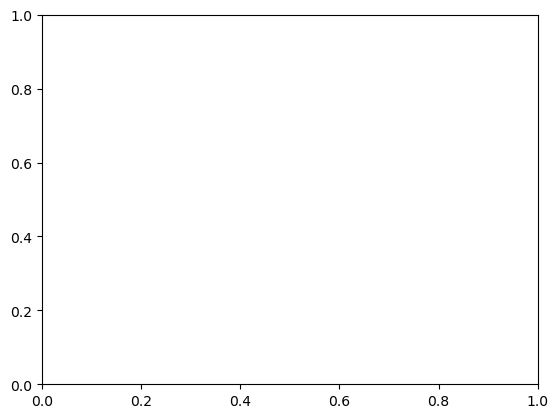

In [36]:
fig, ax = plt.subplots()
ax.plot(tot_train_loss, 'r', label='train')
ax.plot(tot_val_loss, 'b', label='val')
ax.set_title('loss')
ax.legend()


fig, ax = plt.subplots()
ax.plot(tot_train_err, 'r', label='train')
ax.plot(tot_val_err, 'b', label='val')
ax.set_title('error')
ax.legend()


In [30]:
# def predict(model, dataloader):
    
#     # Send model to GPU if available
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)

#     model.eval()
    
#     predicted_outputs = []
#     error = []
    
#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)
            
#             if type(loaded_model) == FFNN:
#                 # Linearize inputs torch.Size([batch, features, timestamps]) into torch.Size([batch, features*timestamps])
#                 inputs = inputs.view(inputs.shape[0], -1)
#             outputs = model(inputs)

#             error.append(mean_absolute_error(targets.view(-1).cpu().numpy(), outputs.view(-1).cpu().detach().numpy()))
#             predicted_outputs.append(outputs)
            
#     return torch.cat(predicted_outputs, dim=0), error
#     # return torch.stack(predicted_outputs), error

In [39]:
# Evaluate on:
mot, dat_load = -1, test_dataloader
mot, dat_load = -2, val_dataloader

In [40]:
# original embedding

EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]
encoded_frames: tp.List[EncodedFrame] = []

original_codes = encodec_model.quantizer.encode(embeddings_motifs[mot, :, neural_samp_hist:].unsqueeze(0), encodec_model.frame_rate, encodec_model.bandwidth)
original_codes = original_codes.transpose(0, 1)
encoded_frames.append((original_codes, scales[mot]))

original_audio = encodec_model.decode(encoded_frames)
original_audio.shape

# Reconvert decoded audio to original sampling rate
model_sr, target_sr = encodec_model.sample_rate, fs_audio
resamp_original_audio = convert_audio(original_audio, model_sr, target_sr, target_channels=1) #[2xN] if model 48kHz

resamp_original_audio.shape

torch.Size([1, 1, 18500])

In [41]:
# Decoded embedding

# prediction = predict(ffn_model, dat_load).permute(1,2,0)
prediction, error = ffnn_predict(ffnn_model, dat_load)
prediction = prediction.unsqueeze(0).permute(0,2,1)

EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]
encoded_frames: tp.List[EncodedFrame] = []

decoded_codes = encodec_model.quantizer.encode(prediction.to('cpu'), encodec_model.frame_rate, encodec_model.bandwidth)
decoded_codes = decoded_codes.transpose(0, 1)
    
encoded_frames.append((decoded_codes, scales[mot]))

decoded_audio = encodec_model.decode(encoded_frames)
decoded_audio.shape

# Reconvert decoded audio to original sampling rate
model_sr, target_sr = encodec_model.sample_rate, fs_audio
resamp_decoded_audio = convert_audio(decoded_audio, model_sr, target_sr, target_channels=1) #[2xN] if model 48kHz

resamp_decoded_audio.shape

torch.Size([1, 1, 18500])

In [42]:
def plot_spectrogram(signal, sr, axis, n_window=512, step_ms=1, f_min=1000, f_max=8000, cut_off=5.5e-05):
    '''
    Plot spectrogram given a signal and sampling rate (and figure axis).
    '''
    
    f, tm, sxx = sp.ms_spectrogram(signal, sr, n_window=n_window, step_ms=step_ms, f_min=f_min, f_max=f_max, cut_off=cut_off)
    axis.pcolormesh(tm, f, np.log(sxx), cmap='inferno')
    axis.set_axis_off()
    axis.set_ylabel('f (kHz)', fontsize=20)
    axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)

In [43]:
from scipy.io.wavfile import write

write('output.wav', fs_audio, np.int16(resamp_original_audio.squeeze(0).squeeze(0).detach().numpy()))
write('hvc-decoded.wav', fs_audio, np.int16(resamp_decoded_audio.squeeze(0).squeeze(0).detach().numpy()))

/tmp/ipykernel_3082149/3656261154.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_3082149/3656261154.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)


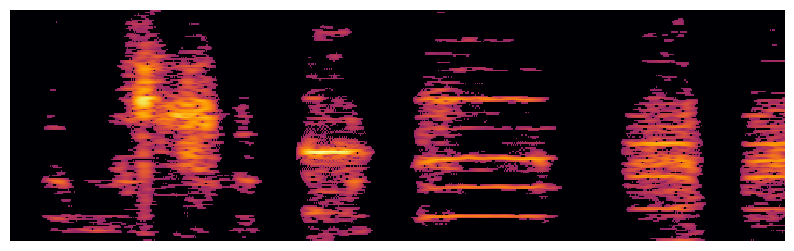

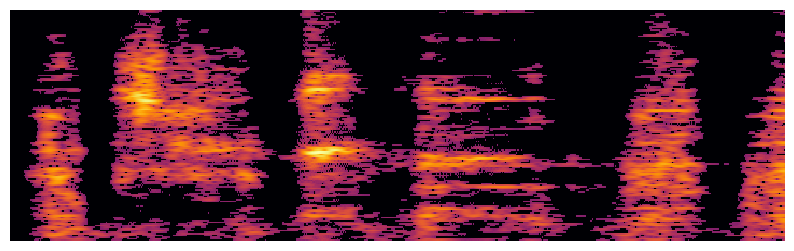

In [44]:
# fig, ax = plt.subplots(2,1, figsize=(10,6))

fig, ax = plt.subplots(figsize=(10,3))
plot_spectrogram(resamp_original_audio.squeeze(0).squeeze(0).detach().numpy(), fs_audio, ax)
# ax[0].set_title('Original')

fig, ax = plt.subplots(figsize=(10,3))
plot_spectrogram(resamp_decoded_audio.squeeze(0).squeeze(0).detach().numpy(), fs_audio, ax)
# ax[1].set_title('Decoded')

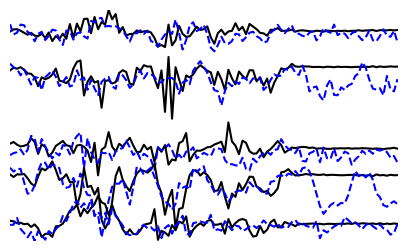

In [36]:
fig, ax = plt.subplots(figsize=(5,3))

scale = 7

for c in range(5):
    ax.plot(embeddings_motifs[-1, :, neural_samp_hist:].unsqueeze(0)[0, c, :]-c*scale, 'k')
    ax.plot(prediction[0, c, :].to('cpu')-c*scale, 'b--')
    ax.set_axis_off()

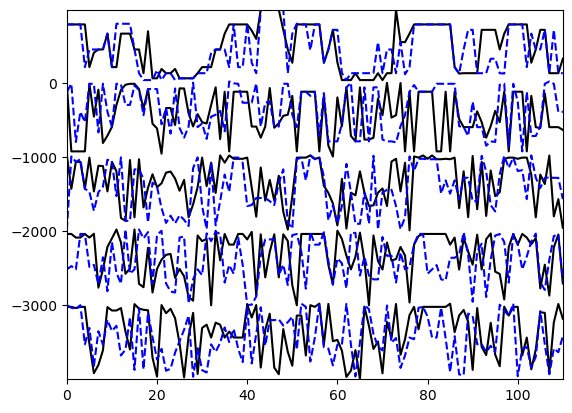

In [37]:
scale=1000

for c in range(5):
    plt.plot(original_codes[0, c, :]-c*scale, 'k')
    plt.plot(decoded_codes[0, c, :]-c*scale, 'b--')

In [41]:
# save = False

# if save == True: 
#     models_dir = os.getcwd() + '/models'

#     if not os.path.exists(models_dir):
#         os.makedirs(models_dir)

#     # save the model to disk
#     filename = models_dir + '/ffnn_model_HVCtrajectories_' + 'epochs' + str(num_epochs) + '_lr' + str(lr) + '.pkl'
#     pkl.dump(ffn_model, open(filename, 'wb'))
    

In [26]:
# models_dir = os.getcwd() + '/models'
# filename = models_dir + '/ffnn_model_RAtrajectories_epochs40000_lr0.0005.pkl'

# # Load model from pickle
# loaded_model = pkl.load(open(filename, 'rb'))

In [ ]:
# save = False

# if save == True: 
#     models_dir = os.getcwd() + '/models'

#     if not os.path.exists(models_dir):
#         os.makedirs(models_dir)

#     # save the model to disk
#     filename = models_dir + '/save_loaders' + '.pkl'
#     pkl.dump(ffn_model, open(filename, 'wb'))

In [38]:
print('Number of params: ', sum(p.numel() for p in ffnn_model.parameters() if p.requires_grad))
num_params = sum(p.numel() for p in ffnn_model.parameters() if p.requires_grad)

Number of params:  738688


In [39]:
save = False

if save == True: 
    models_dir = os.getcwd() + '/models_statedict'

    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
        
    # save the model's state dict
    filename = models_dir + '/ffnn_model_HVC-RAtrajectories_' + 'num_params' + str(num_params) + '_epochs' + str(num_epochs) + '_lr' + str(lr) + '.pkl'

    torch.save({
                'input_dim': input_dim,
                'output_dim': output_dim,
                'neural_samp_hist': neural_samp_hist,
                'epoch': num_epochs,
                'model_state_dict': ffnn_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_dataloader': train_dataloader,
                'val_dataloader': val_dataloader,
                'test_dataloader': test_dataloader
                }, filename)